In [337]:
"""
Author(s): Yuqin Cui
Created: 2019-05-25
Edited: 2019-05-25
(Unfinished)
"""

'\nAuthor(s): Yuqin Cui\nCreated: 2019-05-25\nEdited: 2019-05-25\n(Unfinished)\n'

In [338]:
"""
So the idea is:
Based on the hier_tree, we cut the tree at k level, make k clusters as k supernode.
The blockage is that the distance between supernode is hard to trace (Need to think about some algorithm)
But to make things easy, we can just provide the pre-options that "You dataset is too large to handle, pls choose the
cluster method to generate k supernodes and we will give you k graphs of adjacency matrix and node-link diagram"
"""

'\nSo the idea is:\nBased on the hier_tree, we cut the tree at k level, make k clusters as k supernode.\nThe blockage is that the distance between supernode is hard to trace (Need to think about some algorithm)\nBut to make things easy, we can just provide the pre-options that "You dataset is too large to handle, pls choose the\ncluster method to generate k supernodes and we will give you k graphs of adjacency matrix and node-link diagram"\n'

In [339]:
import numpy as np
import pandas as pd
import panel as pn
import param
import hvplot.pandas
from colorcet import palette

In [340]:
fname = 'GephiMatrix_author_similarity.csv'
f = open(fname, 'r')

# Get author names
line1 = f.readline()
names = line1[1:].split(';');

seen = {}
dupes = []

for index, name in enumerate(names):
    if name not in seen:
        seen[name] = 1
    else:
        if seen[name] == 1:
            dupes.append((index, name))
        seen[name] += 1

# add 1, 2 etc after the name
for pair in dupes:
    index = pair[0]
    name = pair[1]
    for i in range(seen[name]):
        names[index] = name + str((i+1))
        #print(names[index])

# Read csv
df = pd.read_csv(f, names=names, sep=';')

# Fix it
df = df.reset_index(level=1)
names.append("delete")
names = [name.replace('_', ' ') for name in names]
df.columns = names
del df["delete"]
df.set_index([df.columns], inplace=True)

# Get names again for later use
names = df.columns.tolist()

# Get 150*150 sub matrix since otherwise the plot is very slow..
df = df.head(20)[names[0:20]]
names = df.columns.tolist()

df_original = df.copy()

df

,Jim Thomas,Eleftherios Koutsofios,Lawrence A. Rowe,Jonathan I. Helfman,Mary Brewster,Min Chen,Christopher G. Healey,Mac Holden,M. Gray,Jason Stewart,Volker Vogelmann,Benjamin B. Bederson,Maureen Tingley,C. K. Yung,S. Joy Mountford,L. D. Bergman,Rich Gossweiler,M. Maruyama,David P. Helmbold,C. Dunmire
Jim Thomas,1.000000,0.097384,0.125630,0.109691,0.275405,0.195006,0.196239,0.317986,0.407599,0.000000,0.280886,0.450054,0.218693,0.230571,0.324517,0.139374,0.213497,0.362278,0.355599,0.189934
Eleftherios Koutsofios,0.097384,1.000000,0.223607,0.144620,0.281718,0.235008,0.383180,0.365148,0.132508,0.000000,0.539157,0.214392,0.194625,0.136797,0.159544,0.248069,0.066667,0.158761,0.168034,0.056344
Lawrence A. Rowe,0.125630,0.223607,1.000000,0.242536,0.094491,0.181902,0.123579,0.255155,0.027778,0.000000,0.246598,0.343203,0.043519,0.401478,0.031745,0.346688,0.111803,0.184327,0.219179,0.000000
Jonathan I. Helfman,0.109691,0.144620,0.242536,1.000000,0.229175,0.294118,0.173840,0.049507,0.053897,0.000000,0.279108,0.277463,0.295540,0.111283,0.272773,0.201802,0.433861,0.357647,0.243011,0.000000
Mary Brewster,0.275405,0.281718,0.094491,0.229175,1.000000,0.297927,0.336302,0.115728,0.356966,0.000000,0.372822,0.580645,0.312527,0.216777,0.174834,0.157243,0.169031,0.356087,0.142014,0.142857
Min Chen,0.195006,0.235008,0.181902,0.294118,0.297927,1.000000,0.278743,0.148522,0.175165,0.000000,0.279108,0.325029,0.147770,0.139104,0.404760,0.336336,0.216930,0.228497,0.182258,0.045835
Christopher G. Healey,0.196239,0.383180,0.123579,0.173840,0.336302,0.278743,1.000000,0.292616,0.335037,0.000000,0.467275,0.458058,0.225880,0.255159,0.128226,0.301618,0.315018,0.242976,0.202757,0.102759
Mac Holden,0.317986,0.365148,0.255155,0.049507,0.115728,0.148522,0.292616,1.000000,0.158763,0.204124,0.302020,0.313584,0.106600,0.093659,0.170328,0.113228,0.045644,0.100335,0.600789,0.077152
M. Gray,0.407599,0.132508,0.027778,0.053897,0.356966,0.175165,0.335037,0.158763,1.000000,0.000000,0.273998,0.374073,0.232104,0.025491,0.135041,0.154083,0.024845,0.145641,0.153077,0.041996
Jason Stewart,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.204124,0.000000,1.000000,0.000000,0.065372,0.174078,0.000000,0.036280,0.000000,0.000000,0.000000,0.000000,0.000000


In [341]:
from scipy import cluster

import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
from fastcluster import linkage

In [342]:
# #order original matrix based on index provided

# def reordercol(df, order):
#     secondIndex = []
#     new_df = df
#     new_df['nindex'] = np.arange(len(new_df))
#     for i in order:
#         secondIndex += new_df.index[new_df['nindex'] == i].tolist()
#     new_df.drop('nindex',axis=1, inplace = True)
#     a = new_df.reindex( index = secondIndex)
#     return a

# def reorderrow(df, order):
#     a = df.values
#     permutation = order
#     return a[:,permutation]

# def reorder_input_df(df, order):
#     reorder_col = reordercol(df, order)
#     finish = reorderrow(reorder_col, order)
#     return finish

In [343]:
def traversal_tree(hier_tree, number_of_node, current_index):
    if current_index < number_of_node:
        return [current_index]
    else:
        return (traversal_tree(hier_tree,number_of_node, int(hier_tree[current_index-number_of_node][1])) + 
                traversal_tree(hier_tree,number_of_node,int(hier_tree[current_index-number_of_node][0])))

In [344]:
def compute_serial_matrix(df,method="ward", dist_metric = "euclidean"):
    #define the dist_mat by different dist_metric mathod in fast_clustering package
    dist_mat = squareform(pdist(df, metric=dist_metric))    
    #hierar tree was got from package "fast-clustering"
    hierar_tree = linkage(squareform(dist_mat), method=method,preserve_input=True)   
    #The order implied by the hierarhical tree
    reordered_index = traversal_tree(hierar_tree, len(dist_mat), 2*len(dist_mat)-2)
    seriated_dist = np.zeros((len(dist_mat),len(dist_mat)))
    a,b = np.triu_indices(len(dist_mat),k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    return reordered_index, hierar_tree, seriated_dist

In [345]:
res_order, res_linkage, dis_matrix = compute_serial_matrix(df,method="ward", dist_metric = "euclidean")
#linkage(squareform(pdist(df, metric="euclidean")), method="ward",preserve_input=True)
#res_linkage
Z = res_linkage
print(Z)
print(res_order)

[[13.         15.          0.57024016  2.        ]
 [ 7.         18.          0.69958594  2.        ]
 [ 4.         11.          0.77353117  2.        ]
 [ 1.         10.          0.90033912  2.        ]
 [ 6.         23.          0.96388936  3.        ]
 [ 5.         14.          0.9669351   2.        ]
 [ 3.         16.          0.99125509  2.        ]
 [ 0.          8.          0.99852891  2.        ]
 [17.         22.          1.13526016  3.        ]
 [12.         26.          1.20234282  3.        ]
 [ 2.         20.          1.21613545  3.        ]
 [27.         28.          1.27890521  5.        ]
 [19.         30.          1.3883106   4.        ]
 [25.         29.          1.51854657  5.        ]
 [24.         31.          1.5906448   8.        ]
 [ 9.         21.          1.79111001  3.        ]
 [33.         35.          1.94294513  8.        ]
 [34.         36.          2.14705723 16.        ]
 [32.         37.          2.30454729 20.        ]]
[18, 7, 9, 16, 3, 12, 14, 5, 1

In [346]:
df

,Jim Thomas,Eleftherios Koutsofios,Lawrence A. Rowe,Jonathan I. Helfman,Mary Brewster,Min Chen,Christopher G. Healey,Mac Holden,M. Gray,Jason Stewart,Volker Vogelmann,Benjamin B. Bederson,Maureen Tingley,C. K. Yung,S. Joy Mountford,L. D. Bergman,Rich Gossweiler,M. Maruyama,David P. Helmbold,C. Dunmire
Jim Thomas,1.000000,0.097384,0.125630,0.109691,0.275405,0.195006,0.196239,0.317986,0.407599,0.000000,0.280886,0.450054,0.218693,0.230571,0.324517,0.139374,0.213497,0.362278,0.355599,0.189934
Eleftherios Koutsofios,0.097384,1.000000,0.223607,0.144620,0.281718,0.235008,0.383180,0.365148,0.132508,0.000000,0.539157,0.214392,0.194625,0.136797,0.159544,0.248069,0.066667,0.158761,0.168034,0.056344
Lawrence A. Rowe,0.125630,0.223607,1.000000,0.242536,0.094491,0.181902,0.123579,0.255155,0.027778,0.000000,0.246598,0.343203,0.043519,0.401478,0.031745,0.346688,0.111803,0.184327,0.219179,0.000000
Jonathan I. Helfman,0.109691,0.144620,0.242536,1.000000,0.229175,0.294118,0.173840,0.049507,0.053897,0.000000,0.279108,0.277463,0.295540,0.111283,0.272773,0.201802,0.433861,0.357647,0.243011,0.000000
Mary Brewster,0.275405,0.281718,0.094491,0.229175,1.000000,0.297927,0.336302,0.115728,0.356966,0.000000,0.372822,0.580645,0.312527,0.216777,0.174834,0.157243,0.169031,0.356087,0.142014,0.142857
Min Chen,0.195006,0.235008,0.181902,0.294118,0.297927,1.000000,0.278743,0.148522,0.175165,0.000000,0.279108,0.325029,0.147770,0.139104,0.404760,0.336336,0.216930,0.228497,0.182258,0.045835
Christopher G. Healey,0.196239,0.383180,0.123579,0.173840,0.336302,0.278743,1.000000,0.292616,0.335037,0.000000,0.467275,0.458058,0.225880,0.255159,0.128226,0.301618,0.315018,0.242976,0.202757,0.102759
Mac Holden,0.317986,0.365148,0.255155,0.049507,0.115728,0.148522,0.292616,1.000000,0.158763,0.204124,0.302020,0.313584,0.106600,0.093659,0.170328,0.113228,0.045644,0.100335,0.600789,0.077152
M. Gray,0.407599,0.132508,0.027778,0.053897,0.356966,0.175165,0.335037,0.158763,1.000000,0.000000,0.273998,0.374073,0.232104,0.025491,0.135041,0.154083,0.024845,0.145641,0.153077,0.041996
Jason Stewart,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.204124,0.000000,1.000000,0.000000,0.065372,0.174078,0.000000,0.036280,0.000000,0.000000,0.000000,0.000000,0.000000


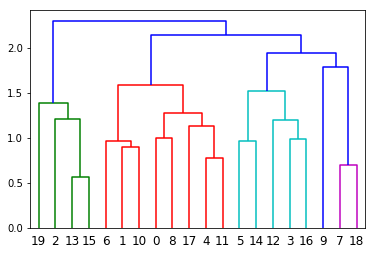

In [347]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

plt.figure()
dn = hierarchy.dendrogram(Z)


In [348]:
# hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
# dn1 = hierarchy.dendrogram(Z,above_threshold_color='y')
# hierarchy.set_link_color_palette(None)  # reset to default after use
# plt.show()

In [349]:
#n_cluster is the number of clusters users want to make, here use example, n_cluster = 5
Cut_Tree = cluster.hierarchy.cut_tree(Z, n_clusters= 5)

In [355]:
#first convert cut_tree to 1D array and then count how many elements in each supernode
cut_tree_array = np.sqrt(np.square(Cut_Tree).sum(1))
cut_tree_array = cut_tree_array.astype(int)
cluster_element_number = np.array(np.unique(cut_tree_array, return_counts=True)).T

cut_tree_array

array([0, 0, 1, 2, 0, 2, 0, 3, 0, 4, 0, 0, 2, 1, 2, 1, 2, 0, 3, 1])

In [351]:
# def Super_node_generate(df, hierar_tree = Z, cluster_number = 5):
#     cut_tree = cluster.hierarchy.cut_tree(hierar_tree, cluster_number)
#     df_try = df.copy()
#     df_try['new_col'] = res_order
#     df_sorted = df_try.sort_values(by=['new_col'])
#     df_sorted.index.tolist()

In [352]:
#order original matrix based on index provided
def author_reorder_list(df,order):
    secondIndex = []
    new_df = df
    new_df['nindex'] = np.arange(len(new_df))
    for i in order:
        secondIndex += new_df.index[new_df['nindex'] == i].tolist()
    new_df.drop('nindex',axis=1, inplace = True)
    a = new_df.reindex( index = secondIndex)
    return a.index.values.tolist()

def reordercol(df, order):
    secondIndex = []
    new_df = df
    new_df['nindex'] = np.arange(len(new_df))
    for i in order:
        secondIndex += new_df.index[new_df['nindex'] == i].tolist()
    new_df.drop('nindex',axis=1, inplace = True)
    a = new_df.reindex( index = secondIndex)
    return a

def reorderrow(df, order):
    a = df.values
    permutation = order
    return a[:,permutation]

def reorder_input_df(df, order):
    reorder_col = reordercol(df, order)
    finish = reorderrow(reorder_col, order)
    return finish


reorder_array = reorder_input_df(df, res_order)

reorder_name = author_reorder_list(df, res_order)

reorder_matrix = pd.DataFrame(reorder_array, index = reorder_name, columns = reorder_name)

#reorder_matrix
reorder_name

['David P. Helmbold',
 'Mac Holden',
 'Jason Stewart',
 'Rich Gossweiler',
 'Jonathan I. Helfman',
 'Maureen Tingley',
 'S. Joy Mountford',
 'Min Chen',
 'Benjamin B. Bederson',
 'Mary Brewster',
 'M. Maruyama',
 'M. Gray',
 'Jim Thomas',
 'Volker Vogelmann',
 'Eleftherios Koutsofios',
 'Christopher G. Healey',
 'L. D. Bergman',
 'C. K. Yung',
 'Lawrence A. Rowe',
 'C. Dunmire']

In [353]:
cluster_element_number

array([[0, 8],
       [1, 4],
       [2, 5],
       [3, 2],
       [4, 1]], dtype=int64)

In [354]:
# for i in cluster_element_number[i][1]:
#     if i > = 0:
        

In [365]:
names, cut_tree_array

cut_tree_series = pd.Series(cut_tree_array)

names_series = pd.Series(names)

In [386]:
cluster_df = pd.concat([names_series, cut_tree_series], axis=1)
#cluster_df.groupby(["1"])
cluster_df

,0,1
0,Jim Thomas,0
1,Eleftherios Koutsofios,0
2,Lawrence A. Rowe,1
3,Jonathan I. Helfman,2
4,Mary Brewster,0
5,Min Chen,2
6,Christopher G. Healey,0
7,Mac Holden,3
8,M. Gray,0
9,Jason Stewart,4


In [394]:
df_cluster = pd.DataFrame({'names': names,
                   'cut_tree_array': cut_tree_array})

In [396]:
df_cluster_grouped = df_cluster.groupby('cut_tree_array')

for names, group in df_cluster_grouped:
    print (names)
    print (group)



0
                     names  cut_tree_array
0               Jim Thomas               0
1   Eleftherios Koutsofios               0
4            Mary Brewster               0
6    Christopher G. Healey               0
8                  M. Gray               0
10        Volker Vogelmann               0
11    Benjamin B. Bederson               0
17             M. Maruyama               0
1
               names  cut_tree_array
2   Lawrence A. Rowe               1
13        C. K. Yung               1
15     L. D. Bergman               1
19        C. Dunmire               1
2
                  names  cut_tree_array
3   Jonathan I. Helfman               2
5              Min Chen               2
12      Maureen Tingley               2
14     S. Joy Mountford               2
16      Rich Gossweiler               2
3
                names  cut_tree_array
7          Mac Holden               3
18  David P. Helmbold               3
4
           names  cut_tree_array
9  Jason Stewart               